# Medium_range National Water Model Forecast
### Workflow for creating a 10-day (member 1) or 8.5-day (members 2-7) streamflow forecast given a date, time, and NHDplus COMID (stream segment identifier)

In [1]:
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import json
import os

import dask 
#from dask.distributed import Client, LocalCluster
# import dask.bag as db
from multiprocessing import cpu_count

%matplotlib inline

## Start the local cluster
#### *__NOTE__*: this is *currently* equal or slower in computation time because of the overhead of the dask scheduler. Without the local cluster, xarray operates serially.

In [ ]:
# num_workers = cpu_count()
# cluster = LocalCluster(n_workers=num_workers)
# client = Client(cluster)
# client

## Set up the Google Cloud File System

In [2]:
fs = gcsfs.GCSFileSystem(project='national-water-model')
# alldays = fs.ls('national-water-model')
# len(alldays)

## Open all netcdf files of interest, concat them into an xarray multifile dataset -- **_1 for each member_**

- This step takes longer than expected due to reading from GCS over the internet

In [3]:
date = '20190730' # yesterdays date
start_time = '00' # start at 00:00 

In [4]:
datepath = f'national-water-model/nwm.{date}'
if 'medium_range_mem' in str(fs.ls(datepath)): 
    xr_datasets = []
    multi_mem = True
    len_forecast = '8.5-day'
    for i in range(1,8):
        mem = str(i)
        open_ncdfs = []
        for i in range(3, 204, 3): # for times 3-240 or 3-204 in steps of 3
            hr = str(i).zfill(3)
            filepath = f'national-water-model/nwm.{date}/medium_range_mem{mem}/nwm.t{start_time}z.medium_range.channel_rt_{mem}.f{hr}.conus.nc'
            file = fs.open(filepath, 'rb')
            open_ncdfs.append(file)
        mfdset = xr.open_mfdataset(open_ncdfs)
        xr_datasets.append(mfdset)

else:
    multi_mem = False
    len_forecast = '10-day'
    open_ncdfs = []
    for i in range(3, 241, 3): # for times 3-240 or 3-204 in steps of 3
        hr = str(i).zfill(3)
        filepath = f'national-water-model/nwm.{date}/medium_range_mem{mem}/nwm.t{start_time}z.medium_range.channel_rt.f{hr}.conus.nc'
        file = fs.open(filepath, 'rb')
        open_ncdfs.append(file)
    mfdset = xr.open_mfdataset(open_ncdfs)
    
print(f'Multi-member: {multi_mem}')

Multi-member: True


## Pull the data from each multifile xarray dataset, make a list of dictionaries

In [43]:
comid = 4512772
outjson = []
for ds in xr_datasets:
    output_da = ds.sel(feature_id=comid)['streamflow']
    times = output_da['time'].values.astype(str)
    arr = output_da.values
    d = {}
    d[ds.attrs['ensemble_member_number']] = dict(zip(times, arr))
    outjson.append(d)

## Dump them into a pandas dataframe

In [68]:
df = pd.concat([pd.read_json(json.dumps(x), orient='index') for x in outjson]).T
df['mean'] = df.mean(axis=1)
df.head()

,1,2,3,4,5,6,7,mean
2019-07-30 03:00:00,171.659996,171.659996,171.659996,171.659996,171.659996,171.659996,171.659996,171.659996
2019-07-30 06:00:00,184.919996,184.919996,184.919996,184.919996,184.919996,184.919996,184.919996,184.919996
2019-07-30 09:00:00,186.599996,186.599996,186.599996,186.599996,186.599996,186.599996,186.599996,186.599996
2019-07-30 12:00:00,184.489996,184.489996,184.489996,184.489996,184.489996,184.489996,184.489996,184.489996
2019-07-30 15:00:00,181.629996,181.629996,181.629996,181.629996,181.629996,181.629996,181.629996,181.629996


## Stats

In [69]:
df.describe()

,1,2,3,4,5,6,7,mean
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,161.629549,160.481638,160.448205,164.732832,170.772981,163.742086,166.557757,164.052150
std,12.720519,12.457196,12.277108,8.899701,11.560883,11.686117,9.393473,9.498107
min,136.199997,134.469997,135.779997,152.149997,159.869996,142.919997,152.679997,150.172854
25%,155.054997,154.624997,154.289997,158.904996,161.259996,157.284996,159.944996,157.884282
50%,161.279996,160.939996,161.099996,162.289996,168.249996,161.889996,163.909996,161.894282
75%,170.379996,168.549996,168.399996,171.579996,174.729996,172.894996,174.164996,171.224282
max,186.599996,186.599996,186.599996,186.599996,204.899995,186.599996,186.599996,186.599996


## Plot it

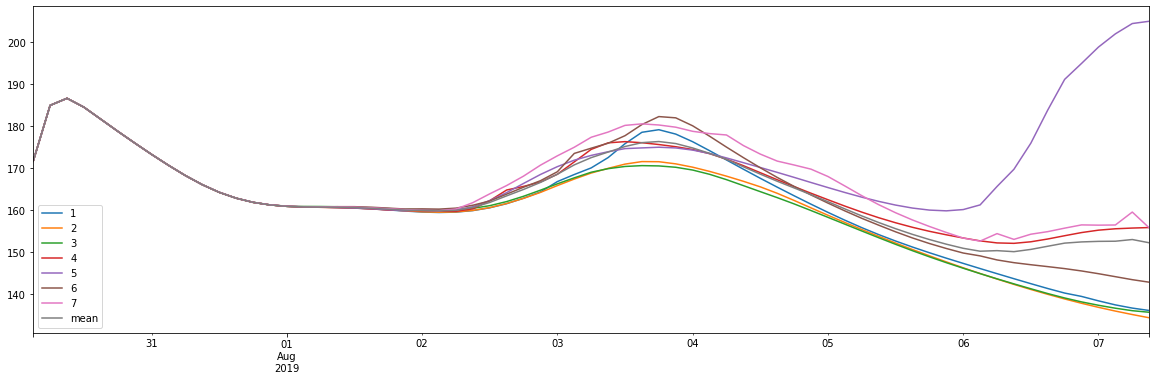

In [76]:
df.plot(figsize=(20,6))